# Практическое задание

#### Импорт библиотек

In [7]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

from sklearn.model_selection import GridSearchCV #поиск по сетке
from sklearn.model_selection import RandomizedSearchCV #рандомизированный поиск
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna

%matplotlib inline
plt.style.use('seaborn')

### Знакомство с данными и их исследование

In [8]:
data = pd.read_csv('data/_train_sem09 (1).csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


Признаки:
* Activity - биологический ответ молекул (целевой признак)
* D1-D1776 - признаки химического состава молекул

Создаем матрицу наблюдений $X$ и вектор ответов $y$

In [9]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение). 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.2)

# **Оптимизация гиперпараметров модели**

## **Логистическая регрессия**

Зафиксируем только метрики, которые были получены без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию:

In [11]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(log_reg.score(X_test, y_test)))
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.75
f1_score на тестовом наборе: 0.78


## GridSearchCV

In [12]:
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
              'C': list(np.linspace(0.01, 1, 10, dtype=float))}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
              'C': list(np.linspace(0.01, 1, 10, dtype=float))}
]
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=1000 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
# %time - замеряет время выполнения
%time grid_search.fit(X_train, y_train) 
# Наилучшая метрика:
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
y_test_pred = grid_search.predict(X_test)
# Либо можем посмотреть любую другую метрику, воспользовавшись методом predict() и передав предсказанные значения в функцию для расчёта метрики
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
# Наилучшая найденная комбинация гиперпараметров сохраняется в атрибуте best_params_:
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

Wall time: 12min 31s
accuracy на тестовом наборе: 0.75
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'C': 0.23, 'penalty': 'l1', 'solver': 'saga'}


c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### Значения метрик не изменились. Это значит, что мы не нашли комбинацию внешних параметров лучше, чем заданы по умолчанию.

Ознакомимся с итоговой полученной моделью

In [13]:
print("Наилучшая модель:\n{}".format(grid_search.best_estimator_))

Наилучшая модель:
LogisticRegression(C=0.23, max_iter=1000, penalty='l1', random_state=42,
                   solver='saga')


А наилучшее значение точности кросс-валидации (значение точности, усредненное по всем разбиениям для данной комбинации гиперпараметров): 

In [14]:
print("Наилучшее значение точности при кросс-валидаци: {:.2f}".format(grid_search.best_score_))

Наилучшее значение точности при кросс-валидаци: 0.77


Отрисуем, как менялись результаты кросс-валидации при различных гиперпараметрах:

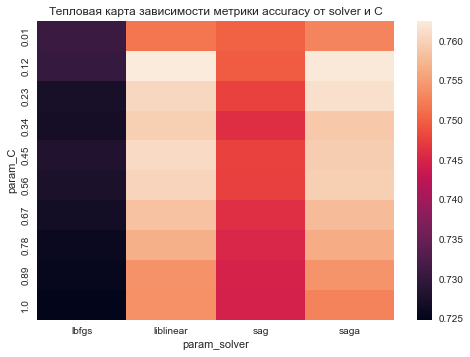

In [15]:
# Взглянем на результаты кросс-валидации
result_cv = pd.DataFrame(grid_search.cv_results_)
# отрисуем, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(grid_search.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns='param_solver')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики accuracy от solver и С') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) #задаем размер графика


Видим, что слабая регуляризация С = 0,12 положительно влияет на метрику и  алгоритмы оптимизации liblinear и saga работают лучше.

## RandomizedSearchCV

In [19]:
#np.linspace(start(от), stop(до), num=50(количество),dtype- тип данных)
param_grid = {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
              'C': list(np.linspace(0.01, 1, 10, dtype=float))},
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_distributions=param_grid, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search.score(X_test, y_test)))
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

Wall time: 1min 49s
accuracy на тестовом наборе: 0.75
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'solver': 'saga', 'penalty': 'l1', 'C': 0.45}


c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Улучшения метрик не произошло. Однако время ощутимо меньше, даже с учетом меньшего количечества параметров.

# Hyperopt

Настроим оптимизацию гиперпараметров

In [29]:
# зададим пространство поиска гиперпараметров
pen = ['l1', 'l2']
sol = ['liblinear', 'saga']
space={'penalty': hp.choice('penalty', ['l1', 'l2']), # тип регуляризации
       'solver': hp.choice('solver', ['liblinear', 'saga']), # алгоритм оптимизации
       'C': hp.uniform('C', low=0.01, high=1) # уровень силы регурялизации
      }

Создаем функцию для минимизации, она должна принимать словарь значений гиперпараметров и возвращать значение целевой функции.

In [30]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': params['penalty'], 
              'solver': params['solver'], 
              'C': float(params['C'])
              }
  
    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    #score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [31]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 20%|██        | 4/20 [00:16<00:53,  3.36s/trial, best loss: -0.7813273963478012]

c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 25%|██▌       | 5/20 [00:25<01:23,  5.54s/trial, best loss: -0.7891698168802058]

c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 50%|█████     | 10/20 [00:42<00:28,  2.88s/trial, best loss: -0.7891698168802058]

c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 60%|██████    | 12/20 [00:54<00:32,  4.00s/trial, best loss: -0.7891698168802058]

c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 80%|████████  | 16/20 [01:06<00:10,  2.70s/trial, best loss: -0.7894982902470989]

c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 90%|█████████ | 18/20 [01:15<00:06,  3.41s/trial, best loss: -0.7894982902470989]

c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|██████████| 20/20 [01:28<00:00,  4.40s/trial, best loss: -0.7894982902470989]
Наилучшие значения гиперпараметров {'C': 0.023051205281475296, 'penalty': 1, 'solver': 0}
Wall time: 1min 28s


In [32]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(
    random_state=random_state, 
    penalty=pen[best['penalty']],
    solver=sol[best['solver']],
    C=float(best['C'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.83
accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.78


Улучшения метрик не произошло. Время обучения еще снизилось.

## Optuna

Настроим оптимизацию гиперпараметров для алгоритма логистической регрессии

In [37]:
def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
    C = trial.suggest_uniform('C', low=0.01, high=1)

    # создаем модель
    model = linear_model.LogisticRegression(penalty=penalty,
                                          solver=solver,
                                          C=C,
                                          random_state=random_state)
    # обучаем модель
    model.fit(X_train, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train))

    return score

In [38]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="linear_model.LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2022-05-13 00:04:36,239] A new study created in memory with name: linear_model.LogisticRegression
c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2022-05-13 00:04:41,500] Trial 0 finished with value: 0.8551641071966277 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.7547893955368594}. Best is trial 0 with value: 0.8551641071966277.
c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2022-05-13 00:04:45,226] Trial 1 finished with value: 0.8768950879320799 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.5984935371927492}. Best is trial 1 with value: 0.8768950879320799.
c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\l

Wall time: 36 s


In [39]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.9999974882136793}
f1_score на обучающем наборе: 0.89


In [40]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.75
f1_score на тестовом наборе: 0.78


График истории оптимизации - отображает количество испытаний на оси Х и метрику на оси Y.

In [41]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

График важности гиперпараметров - помогает понять, какие гиперпараметры вносят больший вклад в минимизацию/максимизацию метрики.

In [42]:
optuna.visualization.plot_param_importances(study, target_name="f1_score")

График контура отношений гиперпараметров показывает связь между различными комбинациями гиперпараметров и значение метрики для этих комбинаций в виде контурного графика.

In [46]:
optuna.visualization.plot_contour(study, params=["penalty",  "solver",  "C"],
                                  target_name="f1_score")

Улучшения метрик не произошло. Время обучения еще снизилось.

# **Случайный лес**

Проделаем аналогичное для RandomForestClassifier().
Сначала посчитаем модель с параметрами по умолчанию и оценим метрику:

In [47]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)

#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.80


Теперь зададим сетку гиперпараметров: 

- 'n_estimators' - количество деревьев в лесу, по умолчанию =100

- 'min_samples_leaf' - минимальное количество объектов в листе;
- 'max_depth': максимальная глубина дерева, не должна быть слишком большой, иначе будет переобучение;

## GridSearchCV()

In [50]:
param_grid = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 5, dtype=int))
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train, y_train) 
y_train_pred = grid_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_forest.score(X_test, y_test)))
y_test_pred = grid_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

Wall time: 35.5 s
f1_score на обучающем наборе: 0.94
accuracy на тестовом наборе: 0.78
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 140}


## RandomizedSearchCV()

In [51]:
param_grid = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_grid, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train, y_train) 
y_train_pred = random_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(random_search_forest.score(X_test, y_test)))
y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

Wall time: 14.7 s
f1_score на обучающем наборе: 0.95
accuracy на тестовом наборе: 0.79
f1_score на тестовом наборе: 0.81
Наилучшие значения гиперпараметров: {'n_estimators': 170, 'min_samples_leaf': 5, 'max_depth': 35}


#### Метрику удалось немного улучшить (по сравнению с моделью логистической регрессии) с помощью обоих методов, но RandomizedSearchCV потребовалось в два раза меньше времени;

# Hyperopt

Настроим оптимизацию гиперпараметров для алгоритма случайного леса.

In [52]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

Создадим функцию для минимизации, она должна принимать словарь значений гиперпараметров и возвращать значение целевой функции.

In [53]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    # score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [54]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [01:29<00:00,  4.46s/trial, best loss: -0.8157677360251723]
Наилучшие значения гиперпараметров {'max_depth': 24.0, 'min_samples_leaf': 2.0, 'n_estimators': 153.0}
Wall time: 1min 29s


In [55]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.99
accuracy на тестовом наборе: 0.79
f1_score на тестовом наборе: 0.81


In [56]:
# если необходимо продолжить подбор, 
# то увеличиваем max_evals(должен быть строго больше, чем на предыдуших итерациях) 
# и используем старый trials
best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=23, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 23/23 [00:11<00:00,  3.87s/trial, best loss: -0.8172667891678256]
Наилучшие значения гиперпараметров {'max_depth': 26.0, 'min_samples_leaf': 2.0, 'n_estimators': 119.0}


Видим, что Hyperot смог улучшить нашу метрику, причем за меньшее время.

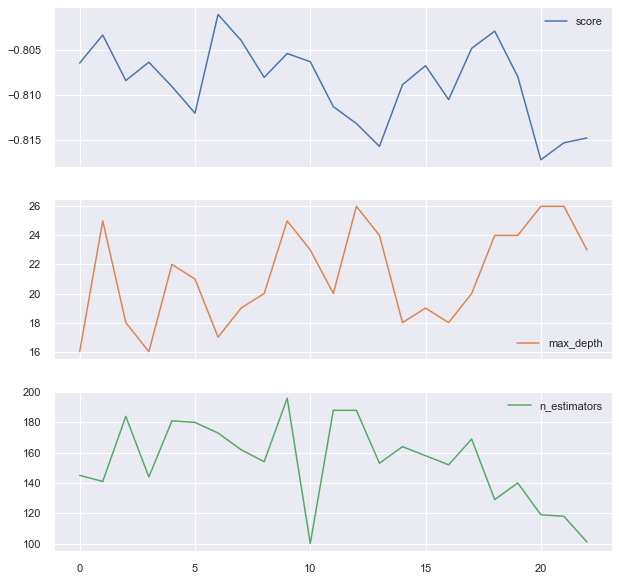

In [57]:
# отрисуем, как менялась точность при различных гиперпараметрах
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'max_depth', 'n_estimators'])
# тепловая карта в данном случае не очень наглядна, возьмем линейный график
tpe_results_df.plot(subplots=True,figsize=(10, 10));

По графикам видно, что лучшая точность достигается в best_params.

## Optuna

Настроим оптимизацию гиперпараметров для алгоритма случайного леса.

In [58]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [59]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2022-05-13 00:35:31,441] A new study created in memory with name: RandomForestClassifier
[I 2022-05-13 00:35:33,944] Trial 0 finished with value: 0.9712362301101591 and parameters: {'n_estimators': 169, 'max_depth': 17, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9712362301101591.
[I 2022-05-13 00:35:36,574] Trial 1 finished with value: 0.9911015648972077 and parameters: {'n_estimators': 163, 'max_depth': 30, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9911015648972077.
[I 2022-05-13 00:35:38,739] Trial 2 finished with value: 0.9093137254901961 and parameters: {'n_estimators': 197, 'max_depth': 10, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.9911015648972077.
[I 2022-05-13 00:35:40,941] Trial 3 finished with value: 0.9009779951100244 and parameters: {'n_estimators': 194, 'max_depth': 11, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.9911015648972077.
[I 2022-05-13 00:35:42,903] Trial 4 finished with value: 0.8908536585365854 and parameters: {'n_

Wall time: 42.6 s


In [60]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 163, 'max_depth': 30, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.99


In [61]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.78
f1_score на тестовом наборе: 0.80


In [62]:
%%time
# можем прододжить подбор, указав n_trials(любое число, которое добавится к предыдущим итерациям) 
study.optimize(optuna_rf, n_trials=10)

[I 2022-05-13 00:37:16,117] Trial 20 finished with value: 0.989874194538202 and parameters: {'n_estimators': 121, 'max_depth': 25, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9911015648972077.
[I 2022-05-13 00:37:18,108] Trial 21 finished with value: 0.9901960784313726 and parameters: {'n_estimators': 132, 'max_depth': 29, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9911015648972077.
[I 2022-05-13 00:37:20,322] Trial 22 finished with value: 0.9734351145038167 and parameters: {'n_estimators': 158, 'max_depth': 28, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9911015648972077.
[I 2022-05-13 00:37:22,021] Trial 23 finished with value: 0.9895897121861605 and parameters: {'n_estimators': 113, 'max_depth': 28, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9911015648972077.
[I 2022-05-13 00:37:23,921] Trial 24 finished with value: 0.9722306988098871 and parameters: {'n_estimators': 135, 'max_depth': 30, 'min_samples_leaf': 3}. Best is trial 1 with value: 0

Wall time: 20.2 s


**Видим, что Optuna также удалось увеличить метрику, но за меньшее время, чем Hyperopt.**

График истории оптимизации - отображает количество испытаний на оси Х и метрику на оси Y.

In [63]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

В нашем случае, все идет верно, метрика максимизируется.

График важности гиперпараметров - помогает понять, какие гиперпараметры вносят больший вклад в минимизацию/максимизацию метрики.

In [64]:
optuna.visualization.plot_param_importances(study, target_name="f1_score")

Из этого графика можно сделать вывод, что стоит обратить большее внимание на настройку гиперпараметра min_sampeles_leaf

График контура отношений гиперпараметров показывает связь между различными комбинациями гиперпараметров и значение метрики для этих комбинаций в виде контурного графика.

In [65]:
optuna.visualization.plot_contour(study, params=["max_depth", "n_estimators"],
                                  target_name="f1_score")

Точки с белым фоном это и есть лучшии комбинации n_estimator, max_depth.














